# TODO

- checker avec Dorian et Julien la meilleure periode pour definir la pluie des recoltes
- choisir la date de debut des vendanges, selon TL plus probablement que selon Latour

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

pheno = pd.read_excel('data/generated_pheno.xlsx', index_col=0)

pheno['Half-harvest'] = (pheno['Begin harvest'] + (pheno['End harvest'] - pheno['Begin harvest'])/2).dt.normalize()

display(pheno.head())

,Budburst,Begin flowering,End flowering,Begin véraison,Half véraison,Begin harvest,End harvest,Budburst - flowering interval,Flowering - véraison interval,Véraison - harvest interval,Growing season duration,Half-harvest
Année,,,,,,,,,,,,
1960,1960-03-18,1960-05-24,1960-05-30,1960-07-20,1960-08-02,1960-09-15,1960-10-06,67,64,44,181,1960-09-25
1961,1961-03-10,1961-05-16,1961-05-30,1961-07-23,1961-08-05,1961-09-17,1961-10-14,67,67,43,191,1961-09-30
1962,1962-04-14,1962-06-08,1962-06-17,1962-08-03,1962-08-16,1962-10-01,1962-10-22,55,60,46,170,1962-10-11
1963,1963-04-08,1963-06-13,1963-06-20,1963-08-13,1963-08-15,1963-10-01,1963-10-28,66,56,47,176,1963-10-14
1964,1964-04-06,1964-06-01,1964-06-14,1964-07-31,1964-08-13,1964-09-21,1964-10-20,56,60,39,168,1964-10-05


In [5]:
weather_st_em = pd.read_csv('data/weather/generated_weather_st_em.csv', parse_dates=['Date']).set_index('Date')
prices_st_em = pd.read_excel('data/prices/generated_average_prices_st_em.xlsx', index_col=0)

weather_medoc = pd.read_csv('data/weather/generated_weather_pauillac.csv', parse_dates=['Date']).set_index('Date')
prices_medoc = pd.read_excel('data/prices/generated_average_prices_medoc.xlsx', index_col=0)

weather_st_em = weather_st_em.drop(['Pl','Ps','Peff', 'SoilHum', 'Evap'], axis = 1)
weather_st_em['Frost'] = (weather_st_em['Tn'] < 0).astype(int) * (-weather_st_em['Tn'])
weather_st_em['DTR'] = weather_st_em['Tx'] - weather_st_em['Tn']

weather_medoc = weather_medoc.drop(['Pl','Ps','Peff', 'SoilHum', 'Evap'], axis = 1)
weather_medoc['Frost'] = (weather_medoc['Tn'] < 0).astype(int) * (-weather_medoc['Tn'])
weather_medoc['DTR'] = weather_medoc['Tx'] - weather_medoc['Tn']

#weather['CI'] = (weather['Tn'] < 15).astype(int)
#weather['Huglin'] = ((weather['Tx']-10) + (weather['Tm']-10))/2

#weather['Heavy Rain'] = (weather['P'] > 40).astype(int)
weather_st_em['Stress'] = 0.5*weather_st_em['ETP'] - weather_st_em['P']
weather_medoc['Stress'] = 0.5*weather_medoc['ETP'] - weather_medoc['P']

#weather['Very high'] = (weather['Tx'] > 36).astype(int) * (weather['Tx'] - 36)
weather_st_em = weather_st_em[['Tn', 'Tm', 'Tx', 'DTR', 'Wind', 'Sun', 'ETP', 'Stress', 'P', 'Frost']]
weather_medoc = weather_medoc[['Tn', 'Tm', 'Tx', 'DTR', 'Wind', 'Sun', 'ETP', 'Stress', 'P', 'Frost']]

ORIG_WEATHER_FEATURES = list(weather_medoc.columns)

#weather['Tm-25'] = (weather['Tx']<30).astype(int) * (weather['Tm']>20).astype(int)
weather_st_em['GDD10'] = ((weather_st_em['Tx']+weather_st_em['Tx'])/2 > 10).astype(int) * ((weather_st_em['Tx']+weather_st_em['Tx'])/2 - 10)
weather_medoc['GDD10'] = ((weather_medoc['Tx']+weather_medoc['Tx'])/2 > 10).astype(int) * ((weather_medoc['Tx']+weather_medoc['Tx'])/2 - 10)

display(weather_medoc.head())

,Tn,Tm,Tx,DTR,Wind,Sun,ETP,Stress,P,Frost,GDD10
Date,,,,,,,,,,,
1960-01-01,9.7,11.9,13.5,3.8,5.8,394.8,1.1,-8.55,9.1,-0.0,3.5
1960-01-02,11.2,12.4,14.0,2.8,8.4,333.7,1.4,-6.80,7.5,-0.0,4.0
1960-01-03,11.1,12.3,13.0,1.9,4.7,254.8,0.8,-1.60,2.0,-0.0,3.0
1960-01-04,12.4,12.9,13.9,1.5,1.5,363.0,0.7,0.35,0.0,-0.0,3.9
1960-01-05,9.9,10.6,11.7,1.8,2.4,331.9,0.4,0.20,0.0,-0.0,1.7


In [6]:
def create_df(weather):
    vintages = list(pheno.index)
    
    df = pd.DataFrame(index = vintages)
    
    events = ['budburst', 'flowering', 'véraison', 'harvest']
    
    intervals = {
        'budburst - flowering' : ['Budburst', 'Begin flowering'],
        'fleur' : ['Begin flowering', 'End flowering'],
        'flowering - véraison' : ['End flowering', 'Half véraison'],
        'véraison - harvest': ['Half véraison', 'Begin harvest'],
        'harvest' : ['Begin harvest', 'End harvest']
    }
    
    # Adding all base features, declined on all intervals
    for feature in ORIG_WEATHER_FEATURES:
        subfeatures_list = [feature + ': '+ interval for interval in intervals.keys()]
            
        for subfeature in subfeatures_list:
            df[subfeature] = 0
    
        for interval in intervals.keys():
            feature_name = feature + ': '+ interval
            for vintage in vintages:
                date_begin, date_end = pheno.loc[vintage, intervals[interval][0]], pheno.loc[vintage, intervals[interval][1]]
                if feature in ['P', 'Hail', 'ETP', 'GDD10', 'Wind', 'Heavy Rain']:
                    df.loc[vintage, feature_name] = weather.loc[date_begin:date_end, feature].sum()  
                    
                #elif feature == 'GDD':
                #    date_debourrement = pheno.loc[vintage, 'debourrement']
                #    df.loc[vintage, feature_name] = weather.loc[date_debourrement:date_end, feature].sum()           
                else:
                    df.loc[vintage, feature_name] = weather.loc[date_begin:date_end, feature].mean()
                    
    df['Growing Season Tm'] = np.nan
    for vintage in vintages: # do not include first vintage
        date_begin = datetime.date(vintage, 4, 1) # Begin on April 1
        date_end = datetime.date(vintage , 9, 30) # End in September

        df.loc[vintage, 'Growing Season Tm'] = weather.loc[date_begin:date_end, 'Tm'].mean()
    print(df['Growing Season Tm'])
    #plt.plot(df['Growing Season Tm'])
    #plt.suptitle('Growing Season Tm')
    #plt.show()
    
    
    #### Adding other features
    
    # Early frost: from October to November
    #df['Prev Fall Frost'] = 0
    #for vintage in vintages[1:]: # do not include first vintage
    #    date_begin = datetime.date(vintage - 1, 9, 1) # Begin on October 1, previous year
    #    date_end = datetime.date(vintage - 1, 11, 1) # End in December
    #    df.loc[vintage, 'Prev Fall Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
    #           
    #    date_begin = datetime.date(vintage - 1, 11, 1) # Begin on October 1, previous year
    #    date_end = datetime.date(vintage - 1, 12, 1) # End in December
    #    df.loc[vintage, 'Prev Fall Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
        
    # Early frost: from October to November
    #df['Winter Frost'] = 0
    #for vintage in vintages[1:]: # do not include first vintage
    #    date_begin = datetime.date(vintage - 1, 12, 1) # Begin on Dec 1, previous year
    #    date_end = pheno.loc[vintage, 'Debourrement'] - datetime.timedelta(days=15) # End in Feb
    #    df.loc[vintage, 'Winter Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
               
    # Winter Tm
    #df['Winter Tn'] = 0
    #for vintage in vintages[1:]: # do not include first vintage
    #    date_begin = datetime.date(vintage - 1, 12, 15) # Begin on October 1, previous year
    #    date_end = datetime.date(vintage , 3, 1) # End mid March
    #    df.loc[vintage, 'Winter Tn'] += weather.loc[date_begin:date_end, 'Tn'].mean()
    
    df['Winter Rain'] = 0
    for vintage in vintages[1:]: # do not include first vintage
        date_begin = datetime.date(vintage - 1, 10, 1) # Begin on October 1, previous year
        date_end = datetime.date(vintage , 3, 1) # End mid March
        df.loc[vintage, 'Winter Rain'] += weather.loc[date_begin:date_end, 'P'].mean()
    
    #df['Debourrement date'] = pheno['debourrement'].dt.dayofyear
    #df['Floraison date'] = pheno['flowering'].dt.dayofyear
    #df['Veraison date'] = pheno['veraison'].dt.dayofyear
    #df['Harvest date'] = pheno['vendanges'].dt.dayofyear

    #df['Dormancy'] = 0
    #weather['CD'] = (weather['Tm'] <= 7.2).astype(int)
    #for vintage in vintages[1:]: # do not include first vintage
    #    date_begin = datetime.date(vintage - 1, 10, 1) # Begin on October 1, previous year
    #    date_end = datetime.date(vintage , 3, 1) # End mid March
    #    
    #    df.loc[vintage, 'Dormancy'] += ((weather.loc[date_begin:date_end, 'CD'] * weather.loc[date_begin:date_end, 'CD'].shift(1) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(2) * weather.loc[date_begin:date_end, 'CD'].shift(3) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(4) * weather.loc[date_begin:date_end, 'CD'].shift(5) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(6) * weather.loc[date_begin:date_end, 'CD'].shift(7) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(8) * weather.loc[date_begin:date_end, 'CD'].shift(9) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(10) * weather.loc[date_begin:date_end, 'CD'].shift(11) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(12) * weather.loc[date_begin:date_end, 'CD'].shift(13)).sum() > 0).astype(int)
    #    
    
    #df['P: veraison - end vendanges'] = df['P: veraison - vendanges'] + df['P: vendanges']
    #df['ETP: veraison - end vendanges'] = df['ETP: veraison - vendanges'] + df['ETP: vendanges']
    df['GDD10'] = 0
    for vintage in vintages: # do not include first vintage
        date_begin = datetime.date(vintage, 4, 1)
        date_end = pheno.loc[vintage, 'End harvest']
        df.loc[vintage, 'GDD10'] += (weather.loc[date_begin:date_end, 'GDD10']).sum()
        
    #df['Enough GDD10'] = (df['GDD10'] > 2530).astype(int)
    df = df.drop(['Frost: flowering - véraison', 'Frost: véraison - harvest', 'Frost: harvest', 'Frost: fleur'], axis=1)
    
    df['Stress'] = 0.5*(df['ETP: flowering - véraison'] + df['ETP: véraison - harvest']) - (df['P: flowering - véraison'] + df['P: véraison - harvest'])
    #df['Stress'] = (df['Stress'] > -100).astype(int) * df['Stress']
    #df = df.drop(['ETP: debourrement - flowering', 'ETP: flowering - veraison', 'ETP: veraison - vendanges'], axis=1)
    #df = df.drop(['Stress: debourrement - flowering', 'Stress: flowering - veraison', 'Stress: veraison - vendanges'], axis=1)
    #df['Evap'] = df['Evap: flowering - veraison'] + df['Evap: veraison - vendanges']
    return df

df_st_em = create_df(weather_st_em)
df_medoc = create_df(weather_medoc)

plt.figure(figsize=(12,4))
linreg = LinearRegression()
linreg.fit(np.array(list(df_medoc.index)).reshape(-1,1), df_medoc[['Tm: flowering - véraison']])
sns.lineplot(x = df_medoc.index, y = df_medoc['Tm: flowering - véraison'], color='lightcoral')
plt.plot(df_medoc.index, linreg.predict(np.array(list(df_medoc.index)).reshape(-1,1)), color='indianred')
plt.suptitle('Evolution of average temperature from flowering to véraison - Pauillac')
plt.tight_layout()
plt.savefig('views/warming.png')
plt.show()

1960    16.473224
1961    17.437158
1962    16.518033
1963    15.720765
1964    17.459563
1965    15.459016
1966    16.572131
1967    16.442077
1968    16.130601
1969    16.615847
1970    16.771585
1971    16.908197
1972    15.051913
1973    17.161749
1974    16.346995
1975    17.021858
1976    17.793989
1977    15.537158
1978    15.897814
1979    16.181967
1980    16.004918
1981    17.006011
1982    17.729508
1983    17.640984
1984    16.694536
1985    17.251366
1986    16.706557
1987    17.196175
1988    17.203279
1989    18.186885
1990    18.051913
1991    17.349180
1992    17.026230
1993    16.734426
1994    17.384153
1995    17.626776
1996    16.969399
1997    18.074317
1998    17.191803
1999    17.974863
2000    17.693989
2001    17.239891
2002    16.847541
2003    19.333333
2004    17.585246
2005    18.248087
2006    18.589617
2007    17.310383
2008    16.624044
2009    17.862842
2010    17.592896
2011    18.353005
2012    17.376503
2013    17.328415
2014    18.115847
2015    19

NameError: name 'LinearRegression' is not defined

<Figure size 864x288 with 0 Axes>

## Important

Only goal of unskewing prices is to put them closer to the 0-1 range, but any transformation that leaves their order untouched does not change the predictive power. HOWEVER, it probably helps training the reg model.


St Emilion:
               skew  kurtosis
Log price  0.432361 -0.108372

Medoc :
               skew  kurtosis
Log price  1.663359  4.270661


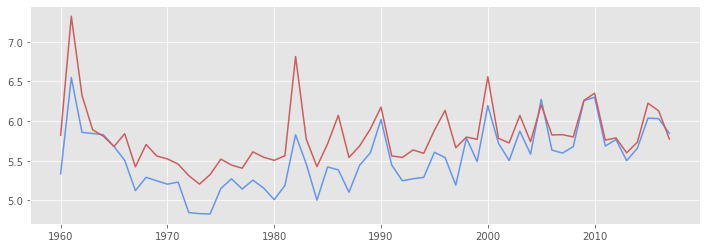

In [11]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
from sklearn.linear_model import LinearRegression


#prices['Anomaly'] = np.nan
#for year in range(1961, 2018):
#    linreg = LinearRegression()
#    linreg.fit(np.array(range(year-10, year)).reshape(-1,1), prices.loc[year-10 : year-1, 'Price'])
#    prices.loc[year, 'Anomaly'] = prices.loc[year, 'Price'] - linreg.predict(np.array(year).reshape(-1,1))
#

price_st_em = np.log(prices_st_em['Average price']).loc[1960:]
price_medoc = np.log(prices_medoc['Average price']).loc[1960:]


######### Yeo Johnson transofrmation

#price = np.log(price)

#pt = PowerTransformer()
#price = pt.fit_transform(np.log(prices['Price'].loc[1961:]).values.reshape(-1,1))/2

#print(df.agg(['skew', 'kurtosis']).T)

plt.plot(price_st_em, color='cornflowerblue')
plt.plot(price_medoc, color='indianred')

df_st_em = df_st_em.loc[1960:]
df_st_em['Log price'] = price_st_em

print('\nSt Emilion:')
print(df_st_em[['Log price']].agg(['skew', 'kurtosis']).T)

df_medoc = df_medoc.loc[1960:]
df_medoc['Log price'] = price_medoc

print('\nMedoc :')
print(df_medoc[['Log price']].agg(['skew', 'kurtosis']).T)

df_st_em.to_excel('data/generated_features_st_em.xlsx')
df_medoc.to_excel('data/generated_features_medoc.xlsx')

Saint-Emilion:


Log price                     1.00
DTR: véraison - harvest       0.61
Stress                        0.58
P: fleur                      0.58
Tn: budburst - flowering      0.55
Stress: fleur                 0.53
Stress: véraison - harvest    0.53
GDD10                         0.52
Wind: fleur                   0.52
Tm: budburst - flowering      0.48
Name: Log price, dtype: float64


Medoc:


Log price                     1.00
Sun: véraison - harvest       0.52
DTR: véraison - harvest       0.50
Stress: véraison - harvest    0.49
Stress                        0.48
P: fleur                      0.45
Wind: harvest                 0.42
Wind: fleur                   0.42
P: véraison - harvest         0.42
Stress: fleur                 0.39
Name: Log price, dtype: float64


Combined:


Log price                     1.000000
DTR: véraison - harvest       0.607578
Stress                        0.579615
P: fleur                      0.577492
Tn: budburst - flowering      0.549977
Stress: fleur                 0.531548
Stress: véraison - harvest    0.527278
GDD10                         0.522875
Wind: fleur                   0.518596
Tm: budburst - flowering      0.475501
Name: Log price, dtype: float64

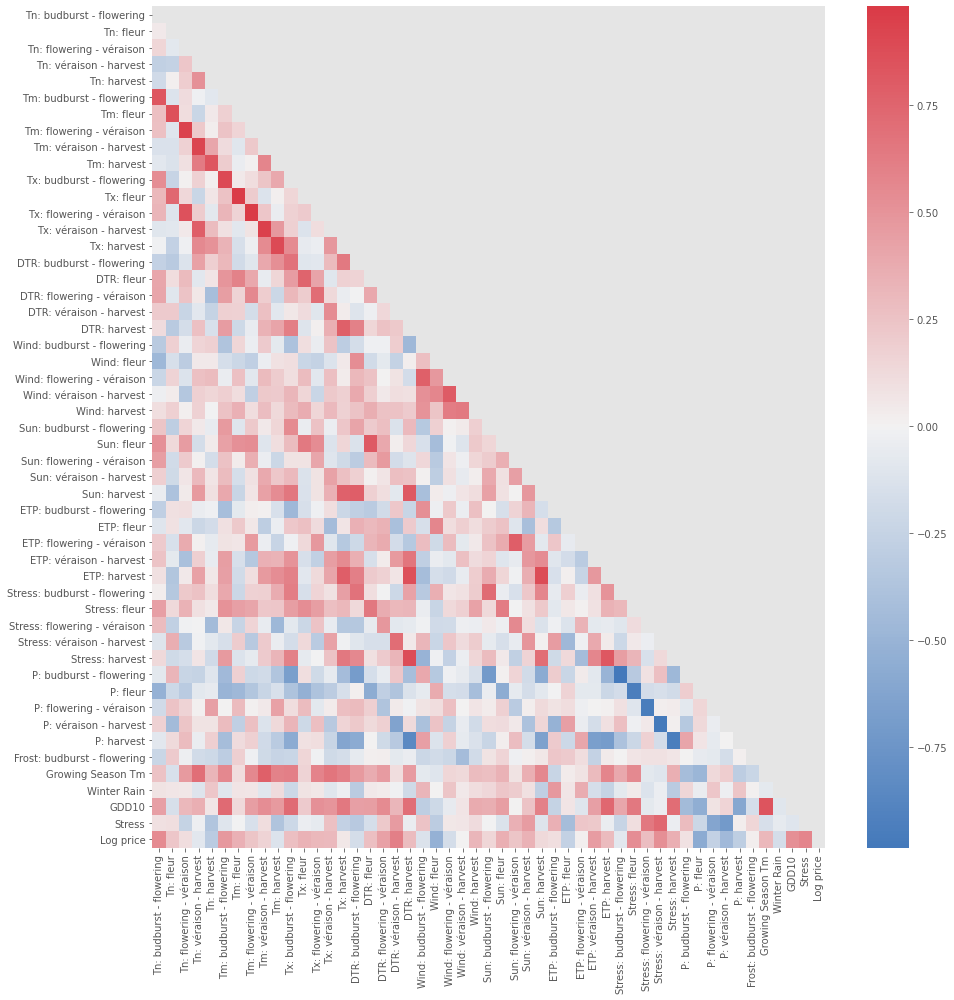

In [12]:
#print(df.loc[1983:1993, :].corr()['Log price'].abs().nlargest(30))
#print(df.loc[1994:2004, :].corr()['Log price'].abs().nlargest(20))
print('Saint-Emilion:')
display(df_st_em.loc[1994:, :].corr()['Log price'].abs().nlargest(10).round(2))
print('\nMedoc:')
display(df_medoc.loc[1994:, :].corr()['Log price'].abs().nlargest(10).round(2))
print('\nCombined:')
display(pd.concat((df_st_em.loc[1994:2017, :], df_st_em.loc[1994:, :]), axis=0).corr()['Log price'].abs().nlargest(10))

#display(df.loc[2005:, :].corr()['Log price'].abs().nlargest(20))

plt.figure(figsize=(14,14))
mask = np.triu(np.ones_like(pd.concat((df_st_em.loc[1994:, :], df_st_em.loc[1994:, :]), axis=0).corr()))

cmap = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(pd.concat((df_st_em.loc[1994:, :], df_st_em.loc[1994:, :]), axis=0).corr(), mask = mask, cmap=cmap)
plt.tight_layout()
plt.savefig('views/heatmap.png')
plt.show()

#### GOOD_FEATURES = ['Stress',  'DTR: veraison - vendanges']: Spearman out-sample of 0.76, BEST TO DATE

# Regression

In [168]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from sklearn.linear_model import Ridge, Lasso, LinearRegression

def model_tester(X, y, first, last, width, fixed_1994):
    coefficients = pd.DataFrame(0, index=range(first, last- width +1), columns = ['const']+X.columns.to_list())
    r2_scores = []
    predictions = pd.DataFrame(index=range(first+ width,last), columns=['Log Price'])
    spearman_scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    
    for year in coefficients.index:
        oldest_vintage = year
        newest_vintage = year +  width -1

        y_train = y.loc[oldest_vintage:newest_vintage, 'Log price']
        #X_train = sm.add_constant(X.loc[oldest_vintage-first:newest_vintage-first,:])
        X_train = X.loc[oldest_vintage-first:newest_vintage-first,:]
        
        #mod = sm.OLS(y_train.values.reshape(-1,1), X_train)
        #res = mod.fit()
        #coefs = pd.Series(res.params)
        #mod = Lasso(alpha=0.005)
        mod = LinearRegression()
        mod.fit(X_train, y_train.values)
        coefs = mod.coef_
        coefficients.loc[year, X_train.columns] = coefs
        coefficients.loc[year, 'const'] = mod.intercept_
        
        r2_scores.append(r2_score(mod.predict(X_train),y_train))
        spearman_scores.append(spearmanr(mod.predict(X_train),y_train)[0])
        
        X_test = X.loc[newest_vintage-first+1:newest_vintage-first+1,:]
        #ones = pd.DataFrame(np.ones(1), index=[newest_vintage-first+1], columns=['const'])
        #X_test = pd.concat((ones, X_test), axis=1)
        
        if fixed_1994:
            if year==1994- width -1:
                mod_base = mod
                
            if year >=1994- width -1:
                print(year+ width +1, ': using 1993 model.')
                predictions.loc[newest_vintage+1] = mod_base.predict(X_test.values)[0]

            else:
                predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]

        else:
            predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]
    return coefficients, r2_scores, spearman_scores, predictions.loc[1994:]

def model_tester_combined(X_medoc, y_medoc, X_st_em, y_st_em, first, last, width, fixed_1994):
    predictions_st_em = pd.DataFrame(index=range(first + width, last), columns=['Log Price'])
    predictions_medoc = pd.DataFrame(index=range(first + width, last), columns=['Log Price'])

    X_medoc = pd.DataFrame(StandardScaler().fit_transform(X_medoc), columns=X_medoc.columns)
    X_st_em = pd.DataFrame(StandardScaler().fit_transform(X_st_em), columns=X_st_em.columns)

    for year in range(first, last-width+1):
        oldest_vintage = year
        newest_vintage = year +  width - 1

        y_medoc_train = y_medoc.loc[oldest_vintage:newest_vintage, 'Log price']
        y_st_em_train = y_st_em.loc[oldest_vintage:newest_vintage, 'Log price']
        y_train = np.concatenate((y_medoc_train, y_st_em_train), axis=0)
        X_medoc_train = np.concatenate((X_medoc.loc[oldest_vintage-first:newest_vintage-first,:].values, np.ones((width, 1))), axis=1)
        X_st_em_train = np.concatenate((X_st_em.loc[oldest_vintage-first:newest_vintage-first,:].values, np.zeros((width, 1))), axis=1)
        X_train  = np.concatenate((X_medoc_train, X_st_em_train), axis = 0)
        
        mod = LinearRegression()
        mod.fit(X_train, y_train)
        
        X_medoc_test = np.concatenate((X_medoc.loc[newest_vintage-first+1:newest_vintage-first+1,:].values, np.ones((1,1))), axis=1)
        X_st_em_test = np.concatenate((X_st_em.loc[newest_vintage-first+1:newest_vintage-first+1,:].values, np.ones((1,1))), axis=1)

        predictions_medoc.loc[newest_vintage+1] = mod.predict(X_medoc_test)[0]
        predictions_st_em.loc[newest_vintage+1] = mod.predict(X_st_em_test)[0]

    return predictions_medoc, predictions_st_em

In [173]:
def regression(df, first, last, width, features):
    #X['Sq Tn: debourrement - floraison'] = X['Tn: debourrement - floraison']**2
    df=df.loc[first:last]
    #df = df.reset_index()
    X = df.drop('Log price', axis=1)[features]#.reset_index(drop=True)
    y = df[['Log price']]
    
    coefficients, r2_scores, spearman_scores, predictions = model_tester(X, y, first, last, width, fixed_1994 = False)
    
    #sns.lineplot(data=coefficients.iloc[:,1:6]).axhline(0., color='black')
    #ax = plt.gca()
    #ax.set_xticklabels([str(year) + ' - ' + str(year + width) for year in range(1955, 2000, 5)])
    #plt.tight_layout()
    #plt.savefig('views/linreg_coefficients_through_time.png')
    #plt.show()
    #
    #plt.figure(figsize=(16,4))
    #sns.lineplot(data=coefficients.iloc[:,0])
    #plt.show()
    #
    #
    #plt.figure(figsize=(16,4))
    #plt.plot(predictions, color='red')
    #plt.plot(y, color='green')
    #plt.savefig('views/Spearman_R_simple_regression.png')
    #plt.show()
    
    return predictions

def score_predictions(predictions, y):  
    spearman_r = round(spearmanr(y.loc[1994:], predictions.loc[1994:])[0], 3)
    mae = round(np.mean(np.abs(predictions.loc[1994:].values- y.loc[1994:].values)), 3)
    r2 = round(r2_score(y.loc[1994:].values, predictions.loc[1994:].values), 3)
    return spearman_r, r2, mae

def r_squared(x, y):
    return 1 - np.sum(np.square(x - y))/np.sum(np.square(x - np.mean(x)))

In [177]:
results_df = pd.DataFrame(index = [
    'Médoc: SpearmanR',
    'Saint-Émilion: SpearmanR',
    'Global: SpearmanR',
    'Médoc: R2',
    'Saint-Émilion: R2',
    'Global: R2',
    'Médoc: MAE',
    'Saint-Émilion: MAE',
    'Global: MAE'
])
y_average = 0.5 * (df_medoc['Log price'] + df_st_em['Log price'])

### R1 : simple regression, without Year, on 20 years. False combined prediction. ###
results_df['R1'] = 0

predictions_medoc = regression(df_medoc, 1960, 2017, 20, ['Stress', 'P: fleur', 'Wind: fleur', 'DTR: véraison - harvest'])
predictions_st_em = regression(df_st_em, 1960, 2017, 20, ['Stress', 'P: fleur', 'Wind: fleur', 'DTR: véraison - harvest'])
predictions_global = 0.5*(predictions_medoc + predictions_st_em)
results_df.iloc[0::3, -1] = score_predictions(predictions_medoc, df_medoc['Log price'])
results_df.iloc[1::3, -1] = score_predictions(predictions_st_em, df_st_em['Log price'])
results_df.iloc[2::3, -1] = score_predictions(predictions_global, y_average)

### R2 : simple regression, with Year, on 20 years. False combined prediction. ###
results_df['R2'] = 0
df_medoc_copy = df_medoc.copy()
df_st_em_copy = df_st_em.copy()
df_medoc_copy['Vintage'] = df_medoc_copy.index
df_st_em_copy['Vintage'] = df_st_em_copy.index

predictions_medoc = regression(df_medoc_copy, 1960, 2017, 20, ['Vintage','Stress', 'P: fleur', 'Wind: fleur', 'DTR: véraison - harvest'])
predictions_st_em = regression(df_st_em_copy, 1960, 2017, 20, ['Vintage','Stress', 'P: fleur', 'Wind: fleur', 'DTR: véraison - harvest'])
predictions_global = 0.5*(predictions_medoc + predictions_st_em)

results_df.iloc[0::3, -1] = score_predictions(predictions_medoc, df_medoc['Log price'])
results_df.iloc[1::3, -1] = score_predictions(predictions_st_em, df_st_em['Log price'])
results_df.iloc[2::3, -1] = score_predictions(predictions_global, y_average)

### R3 : simple regression, without Year, on 20 years. True combined training. ###
results_df['R3'] = 0
first = 1960
last = 2017
width = 20
df_medoc = df_medoc.loc[first:last]
X_medoc = df_medoc.drop('Log price', axis=1)[['Stress', 'P: fleur', 'Wind: fleur', 'DTR: véraison - harvest']]#.reset_index(drop=True)
y_medoc = df_medoc[['Log price']]

df_st_em = df_st_em.loc[first:last]
X_st_em = df_st_em.drop('Log price', axis=1)[['Stress', 'P: fleur', 'Wind: fleur', 'DTR: véraison - harvest']]#.reset_index(drop=True)
y_st_em = df_st_em[['Log price']]

predictions_medoc, predictions_st_em = model_tester_combined(X_medoc, y_medoc, X_st_em, y_st_em, first, last, width, fixed_1994 = False)
predictions_global = 0.5*(predictions_medoc + predictions_st_em)
results_df.iloc[0::3, -1] = score_predictions(predictions_medoc, df_medoc['Log price'])
results_df.iloc[1::3, -1] = score_predictions(predictions_st_em, df_st_em['Log price'])
results_df.iloc[2::3, -1] = score_predictions(predictions_global, y_average)

display(results_df)

df_st_em_copy = df_st_em.copy()
df_st_em_copy['year'] = df_st_em.index

,R1,R2,R3
Médoc: SpearmanR,0.477,0.344,0.585
Saint-Émilion: SpearmanR,0.842,0.768,0.734
Global: SpearmanR,0.757,0.479,0.723
Médoc: R2,0.191,-0.420,0.267
Saint-Émilion: R2,0.338,0.519,0.410
Global: R2,0.361,0.183,0.490
Médoc: MAE,0.233,0.258,0.237
Saint-Émilion: MAE,0.332,0.298,0.302
Global: MAE,0.261,0.261,0.256


In [175]:
residual = df.loc[FIRST+WIDTH+1:LAST, 'Log price'] - predictions.loc[FIRST+WIDTH+1:LAST, 'Log Price']
sns.jointplot(x = df.loc[FIRST+WIDTH+1:LAST,'Winter Tx'], y = residual)
plt.show()

NameError: name 'df' is not defined

# Tree

Spearman: 0.47999191332505026


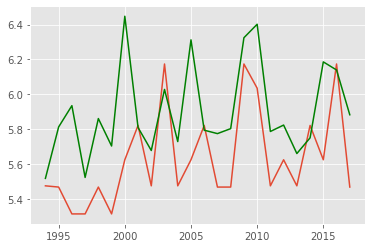

In [79]:
tree_features = ['Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']

df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)
X = X[tree_features]

X_train, X_test = X.loc[1961:1993], X.loc[1994:2017]
y_train, y_test = y.loc[1961:1993], y.loc[1994:2017]

dtree = DecisionTreeRegressor(max_depth=5)
dtree.fit(X_train,y_train.values.ravel())

predictions = dtree.predict(X_test)
plt.plot(range(1994, 2018),predictions)
plt.plot(y_test, color='green')
print('Spearman:', spearmanr(predictions, y_test).correlation)

from sklearn import tree

#tree.plot_tree(dtree)

In [80]:
FIRST, LAST = 1961, 2017
window_width = 32

df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)[GOOD_FEATURES]
y = df[['Log price']]

def model_tester(X, y):
    r2_scores = []
    predictions = pd.DataFrame(index=range(FIRST + window_width +1,LAST +1), columns=['Log price'])
    spearman_scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    
    for year in range(FIRST, LAST - (window_width+1)):
        oldest_vintage = year
        newest_vintage = year + window_width

        y_train = y.loc[oldest_vintage:newest_vintage, 'Log price']
        X_train = X.loc[oldest_vintage-FIRST:newest_vintage-FIRST,:]
        
        mod = DecisionTreeRegressor(max_depth=3)
        mod.fit(X_train, y_train.values.ravel())
        
        r2_scores.append(r2_score(mod.predict(X_train),y_train))
        spearman_scores.append(spearmanr(mod.predict(X_train),y_train)[0])
        
        
        X_test = X.loc[newest_vintage-FIRST+1:newest_vintage-FIRST+1,:]        
        predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]
    
    return r2_scores, spearman_scores, predictions

r2_scores, spearman_scores, predictions = model_tester(X, y)

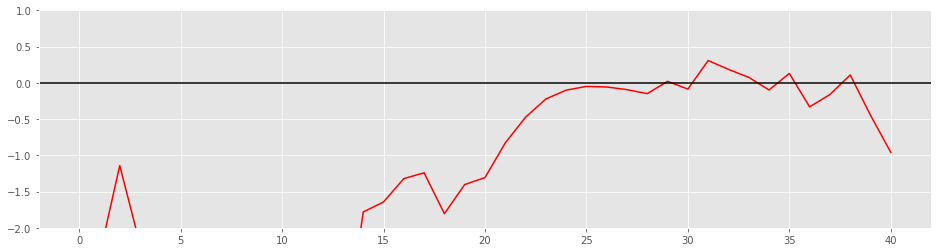

Average in-sample R2 score over the whole period:  -1.995630715015538


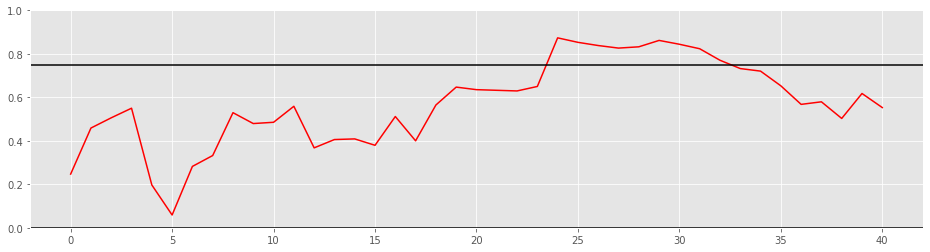

Average in-sample Spearman R over the whole period:  0.5699426111908178


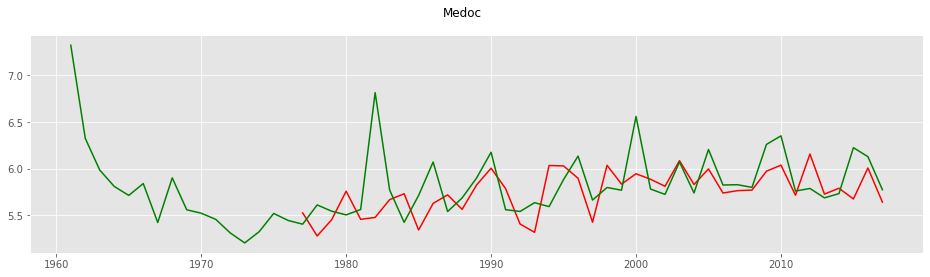

R2 over target period:  -0.01849995775202329
Out-sample Spearman R over the target period:  0.3409090909090909
Out-sample Spearman R over the target period:  0.3409090909090909


In [22]:
plt.figure(figsize=(16,4))
sns.lineplot(data=r2_scores, color='red').axhline(0., color='black')
plt.ylim((-2,1))
plt.plot(0)
plt.savefig('views/In-sample_R2_simple_regression.png')
plt.show()
print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))

plt.figure(figsize=(16,4))
sns.lineplot(data=spearman_scores, color='red').axhline(0., color='black')
plt.ylim((0,1))
plt.axhline(0.75, color='black')
plt.savefig('views/In-sample_Spearman_R_simple_regression.png')
plt.show()
print('Average in-sample Spearman R over the whole period: ',np.mean(spearman_scores))


plt.figure(figsize=(16,4))
plt.plot(predictions, color='red')
plt.plot(y, color='green')

plt.savefig('views/Spearman_R_simple_regression.png')
plt.suptitle(location)
plt.show()
print('R2 over target period: ', r2_score(y.loc[1994:2016], predictions.loc[1994:2016]))
print('Out-sample Spearman R over the target period: ',spearmanr(predictions.loc[1994:2016], y.loc[1994:2016])[0])
print('Out-sample Spearman R over the target period: ',spearmanr(predictions.loc[1994:2016], y.loc[1994:2016])[0])

# Appendix: PCA

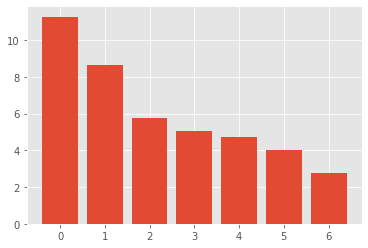

,0,1,2,3,4,5,6
1980,-4.354726,1.794528,0.970380,0.180457,1.694633,-0.256372,-1.641731
1981,0.832289,-2.561261,-1.263189,1.072136,0.367313,-0.680976,-1.267017
1982,2.985240,-0.121465,-2.080035,-0.772342,-1.123292,3.158297,2.591032
1983,1.130416,2.353051,2.173226,-0.231008,-3.864273,-0.755364,-1.200368
1984,-1.813309,-1.169158,-1.870055,-2.802077,1.346254,-1.121126,-0.302894


In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

X = df.drop('Log price', axis=1).loc[1961:1994]

X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1980:,:]


pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)
display(X2.head())

In [83]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt


def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,2]
    n = coeff.shape[0]
    #plt.scatter(xs ,ys) #without scaling
    for i in range(len(labels)):
        plt.arrow(0, 0, coeff[0,i], coeff[1,i],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[0,i]* 1.10, coeff[1,i] * 1.10, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[0,i]* 1.10, coeff[1,i] * 1.10, labels[i], color = 'g', ha = 'center', va = 'center')

            
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')

coef = pca.components_

ax.scatter(coef[0,:] , coef[1, :] , coef[2, :])

for i in range(len(X.columns)):
    ax.text(coef[0,i]+np.mean(coef[0,:])/1000,coef[1,i]+np.mean(coef[1,:])/1000 ,coef[2,i]+np.mean(coef[2,:])/1000, list(X.columns)[i], zdir=None)

# 